# Spatial analysis of variables on the hottest days
This takes the average over all days exceeding a given percentile at a given latitude and plots the spatial distribution of those days in a series of variables.

In [5]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_time_slice, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.papers.byrne_2021 import get_quant_ind
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import numpy_indexed
from scipy.stats import percentileofscore
from scipy import interpolate, integrate

In [4]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'omega', 'ps', 'height', 'precipitation', 'swdn_sfc', 'lwdn_sfc',
            'flux_t', 'flux_lhe', 't_surf']
tau_lw_ref = 1
tau_lw_warm = 1.5
pressure_ft = 500
use_time_start = 360*2
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf), drop=True)
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest').load()]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 2/2 [00:46<00:00, 23.03s/it]


## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [101]:
# For all days warmer than the quantile given at the given latitude: record time and longitude for each simulation
quant_use = 90
lat_use = 10
n_days = int(np.floor((100-quant_use) *ds[0].lon.size * ds[0].time.size /100))
max_ind = {var: np.zeros((n_exp, n_days), dtype=int) for var in ['time', 'lon']}


# define maximum temperature - either surface or lowest level of atmosphere
# max_def = 'surf'
max_def = 'low'

for i in range(n_exp):
    ds_use = ds[i].sel(lat=lat_use,pfull=p_surface/100, method='nearest')
    ds_use = ds_use.temp if max_def == 'low' else ds_use.t_surf
    max_ind['time'][i], max_ind['lon'][i] = np.where(ds_use.to_numpy()>float(ds_use.quantile(quant_use/100)))
    # Maybe here, could do some sort of filtering to only include hottest day in a given time/lon period so don't get
    # lots of neighbouring points
lat_actual = float(ds_use.lat)
lat_ind = np.where(ds[0].lat==lat_actual)[0][0]

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [102]:
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

In [121]:
# Get all variables at surface and free troposphere on hottest day for each year considered
# Do separately for each hemisphere as should be indentical
# Keep all variables in a (2*spatial_sz['lat']+1) x (2*spatial_sz['lon']+1) size grid centered on location of hottest day
spatial_sz = {'lat':10, 'lon':10}
lat_ind_all =  np.arange(lat_ind-spatial_sz['lat'], lat_ind+spatial_sz['lat']+1)
if lat_ind_all.max() >= ds[0].lat.size:
    raise ValueError(f'Max latitude index is {lat_ind_all.max()}, which is out of range. Consider lowering spatial_sz')
lat_ind_all[lat_ind_all<0] += ds[0].lat.size
lat_ind_all[lat_ind_all>=ds[0].lat.size] -= ds[0].lat.size


var_ft = ['temp', 'height', 'ucomp', 'vcomp', 'omega']      # at surface and free troposphere
max_info = {var: np.zeros((n_exp, n_days, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1, ds[0].pfull.size))
            for var in var_ft}
var_surf = ['sphum', 'rh', 'precipitation', 'ps', 'swdn_sfc', 'lwdn_sfc', 'flux_t', 'flux_lhe', 't_surf']
for var in var_surf:
    max_info[var] = np.zeros((n_exp, n_days, 2*spatial_sz['lat']+1, 2*spatial_sz['lon']+1))

ind_use = {}
with tqdm(total=n_exp * n_days, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].isel(lat=lat_ind_all, drop=True)
        ds_use = ds_use.transpose(..., "pfull")         # put pfull at end so can add to max info
        for j in range(n_days):
            # Consider each year in turn
            lon_ind_all =  np.arange(max_ind['lon'][i, j]-spatial_sz['lon'], max_ind['lon'][i, j]+spatial_sz['lon']+1)
            # longitude is a circular index
            lon_ind_all[lon_ind_all<0] += ds_use.lon.size
            lon_ind_all[lon_ind_all>=lon_ind_all.size] -= ds_use.lon.size
            ds_use_j = ds_use.isel(time=max_ind['time'][i, j], lon=lon_ind_all, drop=True)
            for var in var_ft + var_surf:
                if var == 'sphum':
                    max_info[var][i, j] = ds_use_j[var].sel(pfull=np.inf, method='nearest')
                elif var!= 'rh':
                    max_info[var][i, j] = ds_use_j[var]
            pbar.update(1)
# compute near-surface relative humidity from specific humidity and near-surface temperature
max_info['rh'] = max_info['sphum'] / sphum_sat(max_info['temp'][:, :, :, :, -1], p_surface)
# Add empty axis to surface variables so same shape as surf+ft variables

for var in var_surf:
    if len(max_info[var].shape) != 6:
        max_info[var] = np.expand_dims(max_info[var], axis=-1)
# ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

100%|██████████| 46080/46080 [00:47<00:00, 968.10it/s] 


In [133]:
av_info = {var: np.mean(max_info[var], axis=1) for var in max_info}
av_info['ps'] = av_info['ps']/100        # convert to hPa
av_info['height'] = av_info['height']/1000 # Convert to km
# Add empty pressure axis for all surface variables to make plotting easier
for var in av_info:
    if len(av_info[var].shape) == 3:
        av_info[var] = np.expand_dims(av_info[var], axis=-1)

<xarray.DataArray 'lat' (lat: 21)>
array([-18.138971, -15.348365, -12.557756,  -9.767146,  -6.976534,  -4.185921,
        -1.395307,   1.395307,   4.185921,   6.976534,   9.767146,  12.557756,
        15.348365,  18.138971,  20.929574,  23.720174,  26.510769,  29.30136 ,
        32.091944,  34.882521,  37.67309 ])
Coordinates:
  * lat      (lat) float64 -18.14 -15.35 -12.56 -9.767 ... 32.09 34.88 37.67
Attributes:
    long_name:       latitude
    units:           degrees_N
    cartesian_axis:  Y
    edges:           latb

In [146]:
av_info['omega'].shape

(2, 21, 21, 2)

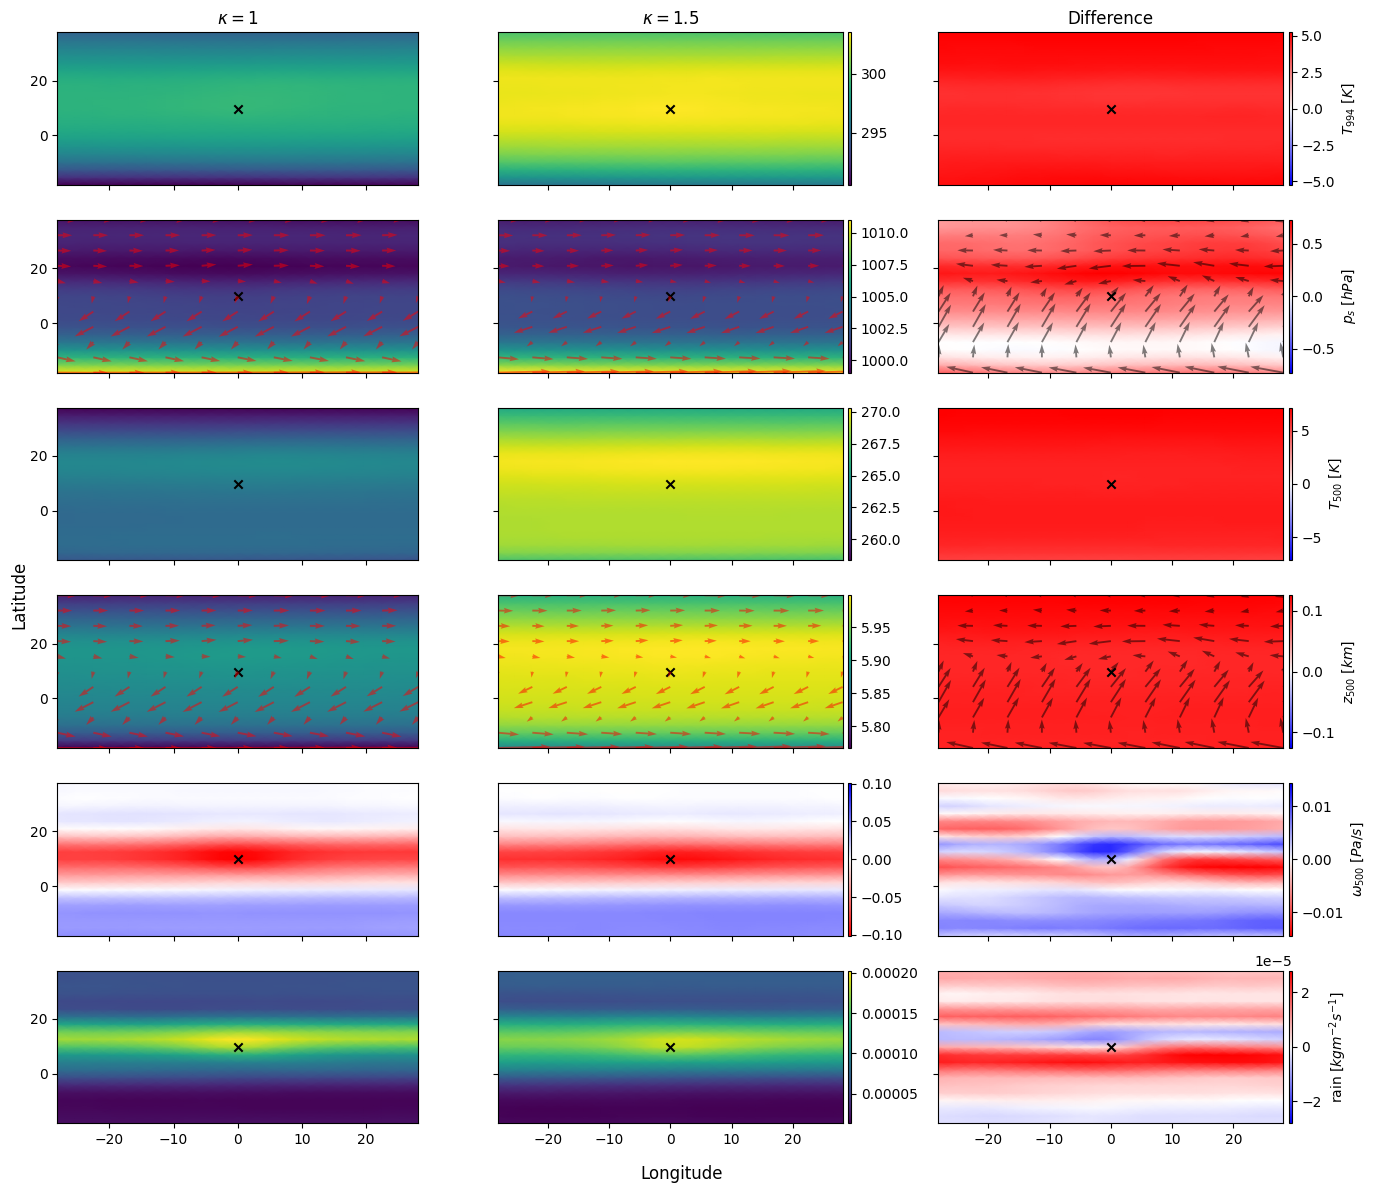

In [169]:
wind_spacing = 2    # larger means less dense arrows
cbar_param = {'aspect': 50, 'pad': 0.015, 'fraction': 0.03}

# centre longitude coordinates on 0
lon_plot = np.arange(-np.diff(ds_use_j.lon)[0]*10, np.diff(ds_use_j.lon)[0]*11, np.diff(ds_use_j.lon)[0])
lat_plot = ds_use_j.lat
max_coord = {'lat': lat_actual, 'lon':0}

var_plot = ['temp', 'ps', 'temp', 'height', 'omega', 'precipitation']
var_p_ind = np.zeros(len(var_plot), dtype=int)
var_p_ind[0] = -1   # first variable is at the surface
var_label = [f"$T_{'{'+str(int(p_surface/100))+'}'}$ [$K$]", '$p_s$ [$hPa$]', f"$T_{'{'+str(pressure_ft)+'}'}$ [$K$]",
             f"$z_{'{'+str(pressure_ft)+'}'}$ [$km$]", f"$\omega_{'{'+str(pressure_ft)+'}'}$ [$Pa/s$]", "rain [$kgm^{-2}s^{-1}$]"]
fig, ax = plt.subplots(6, 3, figsize=(14,12), sharex=True, sharey=True)
for j, var in enumerate(var_plot):
    for i in range(n_exp):
        ax[0, i].set_title(f'$\kappa = {tau_lw[i]}$')
        if var == 'omega':
            clims = [-np.nanmax(np.abs(av_info[var][:, :, :, var_p_ind[j]])),
                     np.nanmax(np.abs(av_info[var][:, :, :, var_p_ind[j]]))]
            cmap = 'bwr_r'
        else:
            clims = [np.nanmin(av_info[var][:, :, :, var_p_ind[j]]),
                     np.nanmax(av_info[var][:, :, :, var_p_ind[j]])]
            cmap = 'viridis'
        im = ax[j, i].pcolormesh(lon_plot, lat_plot, av_info[var][i, :, :, var_p_ind[j]], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord['lon'], max_coord['lat'], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = av_info['ucomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                av_info['vcomp'][i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(lon_plot[::wind_spacing], lat_plot[::wind_spacing], pu, pv, alpha=0.5, color='r')
        if i == n_exp-1:
            plt.colorbar(im, ax=ax[j, i],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
    var_diff = av_info[var][1, :, :, var_p_ind[j]] - av_info[var][0, :, :, var_p_ind[j]]
    clims = [-np.nanmax(np.abs(var_diff)), np.nanmax(np.abs(var_diff))]
    im = ax[j, 2].pcolormesh(lon_plot, lat_plot, var_diff, shading='gouraud',
                             vmin=clims[0], vmax=clims[1], cmap='bwr_r' if var=='omega' else 'bwr')
    ax[j, 2].scatter(max_coord['lon'], max_coord['lat'], marker='x', color='k')
    plt.colorbar(im, ax=ax[j, 2], label=var_label[j],
                 aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
    if var in ['ps', 'height']:
        wind_diff = [av_info[wind][1, ::wind_spacing, ::wind_spacing, var_p_ind[j]] - \
                    av_info[wind][0, ::wind_spacing, ::wind_spacing, var_p_ind[j]] for wind in ['ucomp', 'vcomp']]
        pu, pv = wind_diff[0], wind_diff[1]
        ax[j, 2].quiver(lon_plot[::wind_spacing], lat_plot[::wind_spacing], pu, pv, alpha=0.5, color='k')
ax[0, 2].set_title('Difference')
# fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
#              f' - Day Relative To Hottest Day\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

In [155]:
av_info[var][:, :, :, 0]

array([[[261.5899867 , 261.59715238, 261.60332743, 261.6072887 ,
         261.60938902, 261.61099751, 261.61197347, 261.6107529 ,
         261.60636049, 261.59867681, 261.58765462, 261.57372257,
         261.55800834, 261.54128209, 261.52374264, 261.50614391,
         261.48978228, 261.4750326 , 261.46090439, 261.44638347,
         261.43176634],
        [262.31769611, 262.32760382, 262.33733272, 262.34561662,
         262.35287022, 262.36015975, 262.36674769, 262.37059616,
         262.37066715, 262.36727215, 262.36102001, 262.35247329,
         262.34196266, 262.3293451 , 262.31489977, 262.30020285,
         262.28689381, 262.27491046, 262.26301197, 262.25075345,
         262.23918742],
        [262.52366839, 262.53568264, 262.54824184, 262.56010127,
         262.57093621, 262.58083553, 262.5887606 , 262.59319632,
         262.59401646, 262.59246689, 262.58975529, 262.58624448,
         262.58134061, 262.57406556, 262.56444633, 262.55396963,
         262.54394696, 262.53410315, 262.5

In [10]:
# Get summer datasets so you can make above plot relative to the average summer
summer_months_nh = [7, 8, 9]  # June, July, August
summer_months_sh = [1, 2, 3]  # Dec, Jan, Feb
ds_summer_av = [annual_time_slice(ds_use, include_months=summer_months_nh).sel(pfull=[pressure_ft, np.inf],
                                                                            method='nearest').mean(dim=['time', 'lon']),
                annual_time_slice(ds_use, include_months=summer_months_sh).sel(pfull=[pressure_ft, np.inf],
                                                                            method='nearest').mean(dim=['time', 'lon'])]
ds_plot_av = ds_summer_av[plot_ind[1]].sel(lat=plot_info['lat']).transpose('lat', 'pfull')
# Add pressure dimension to surface variables to make latter plotting simpler
ds_plot_av['ps'] = ds_plot_av['ps'].expand_dims(dim={"pfull": 2}, axis=-1)/100      # convert to hPa
for var in surf_var:
    if var != 'rh':
        if len(ds_plot_av[var].shape) != 2:
            ds_plot_av[var] = ds_plot_av[var].expand_dims(dim={"pfull": 2}, axis=-1)
ds_plot_av['height'] = ds_plot_av['height']/1000    # convert to km

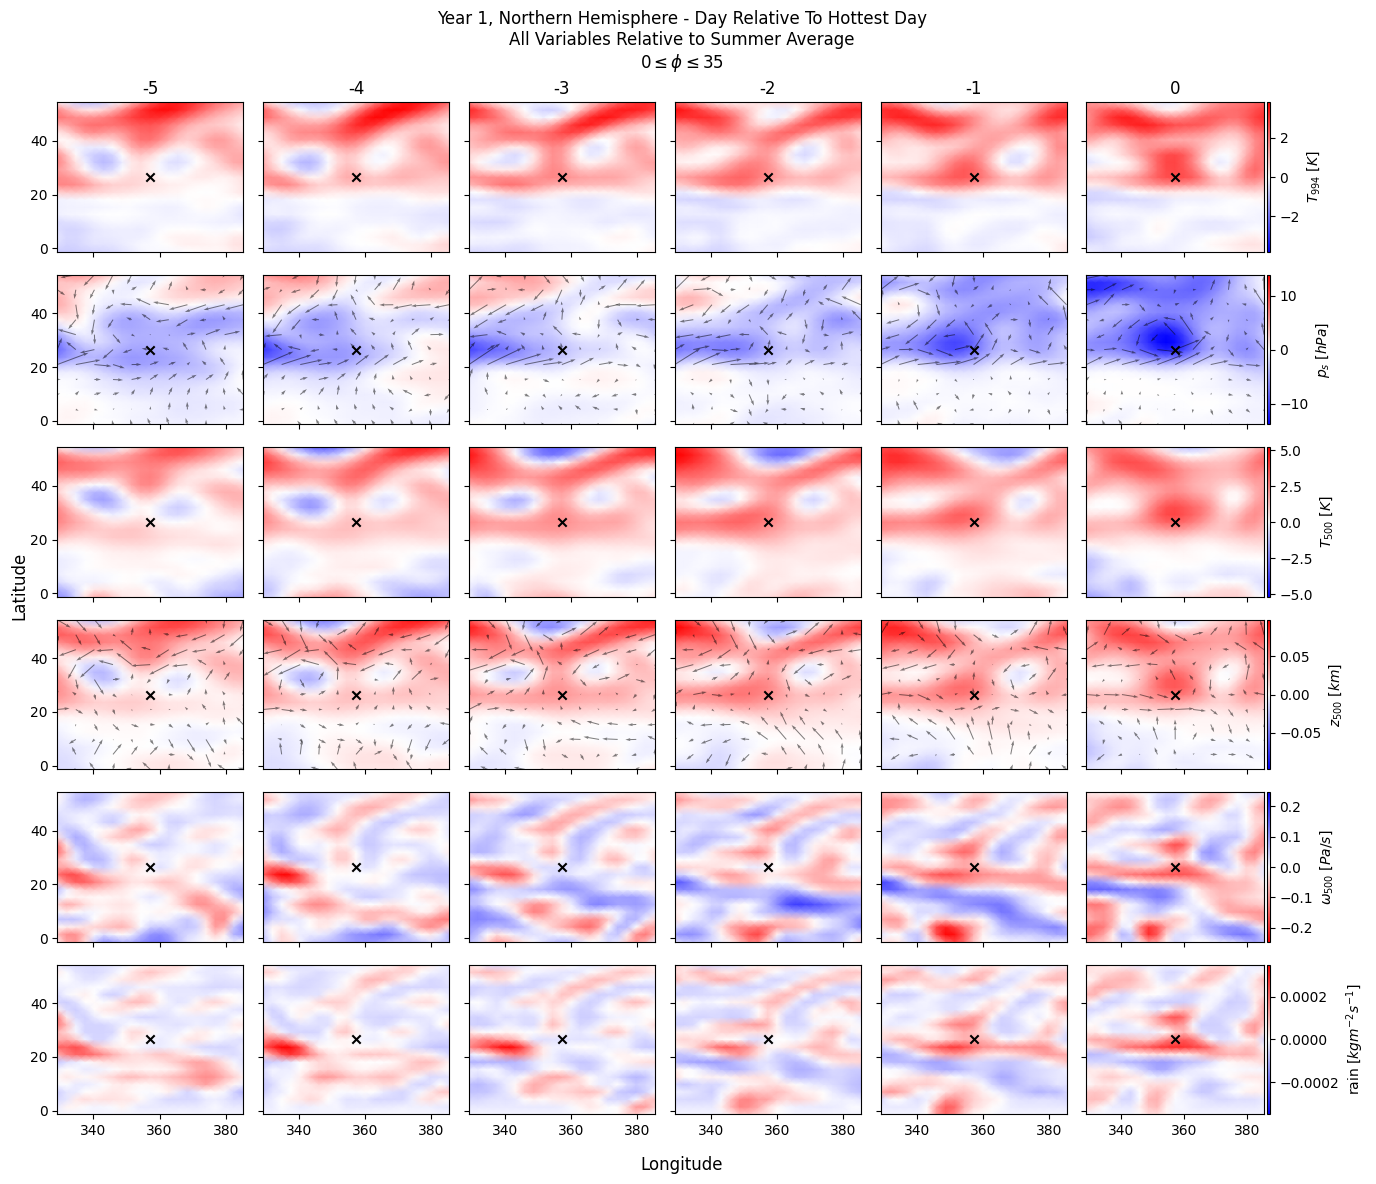

In [11]:
# Plot relative to summer mean
fig, ax = plt.subplots(len(var_name), len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for j, var in enumerate(var_name):
    var_diff = plot_info[var] - np.expand_dims(ds_plot_av[var], axis=(0,2))
    clims = [-np.nanmax(np.abs(var_diff[:, :, :, var_p_ind[j]])),
             np.nanmax(np.abs(var_diff[:, :, :, var_p_ind[j]]))]
    for i in range(len(plot_day)):
        ax[0, i].set_title(plot_day[i])
        if var == 'omega':
            cmap = 'bwr_r'
        else:
            cmap = 'bwr'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], var_diff[i, :, :, var_p_ind[j]], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = (plot_info['ucomp']-np.expand_dims(ds_plot_av['ucomp'], axis=(0,2))
                      )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                (plot_info['vcomp']-np.expand_dims(ds_plot_av['vcomp'], axis=(0,2))
                 )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(plot_info['lon'][::wind_spacing], plot_info['lat'][::wind_spacing], pu, pv, alpha=0.5, color='k')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_label[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             f' - Day Relative To Hottest Day\nAll Variables Relative to Summer Average\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

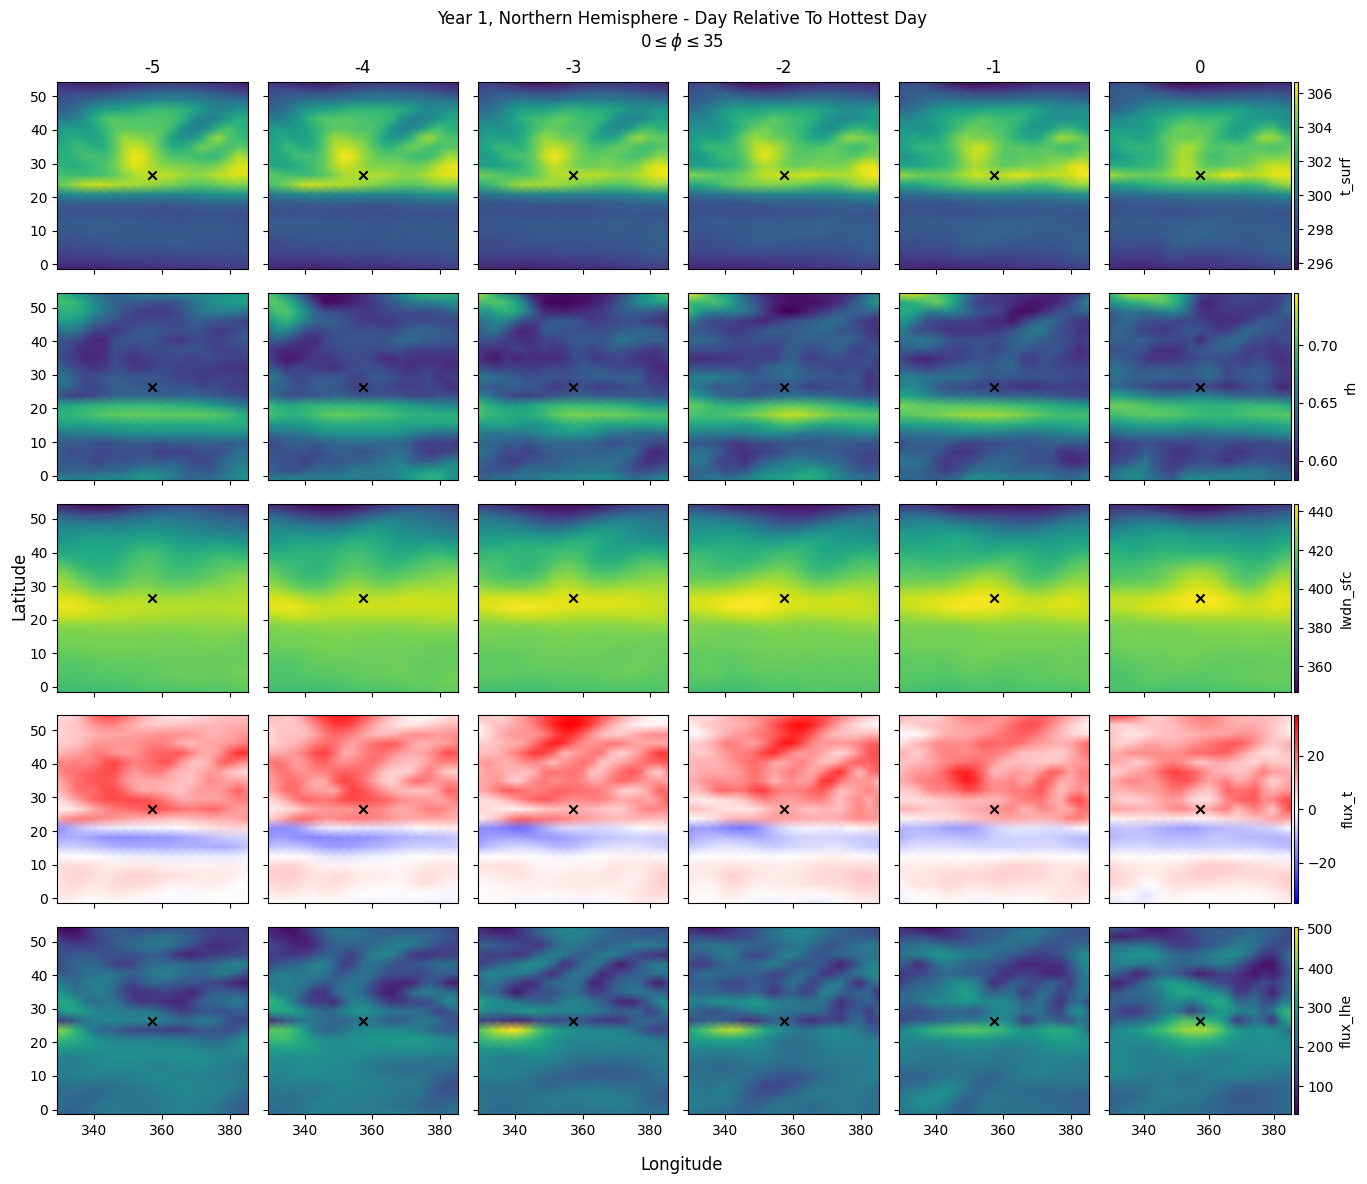

In [12]:
var_name2 = ['t_surf','rh', 'lwdn_sfc', 'flux_t', 'flux_lhe']
# var_label = ['$T_s$ [$K$]', '$p_s$ [$hPa$]', f"$T_{'{'+str(pressure_ft)+'}'}$ [$K$]",
#              f"$z_{'{'+str(pressure_ft)+'}'}$ [$km$]", f"$\omega_{'{'+str(pressure_ft)+'}'}$ [$Pa/s$]", "rain [$kgm^{-2}s^{-1}$]"]
fig, ax = plt.subplots(len(var_name2), len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for i in range(len(plot_day)):
    ax[0, i].set_title(plot_day[i])
    for j, var in enumerate(var_name2):
        if var == 'flux_t':
            clims = [-np.nanmax(np.abs(plot_info[var][:, :, :, 0])),
                     np.nanmax(np.abs(plot_info[var][:, :, :, 0]))]
            cmap = 'bwr'
        else:
            clims = [np.nanmin(plot_info[var][:, :, :, 0]),
                     np.nanmax(plot_info[var][:, :, :, 0])]
            cmap = 'viridis'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], plot_info[var][i, :, :, 0], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_name2[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             f' - Day Relative To Hottest Day\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

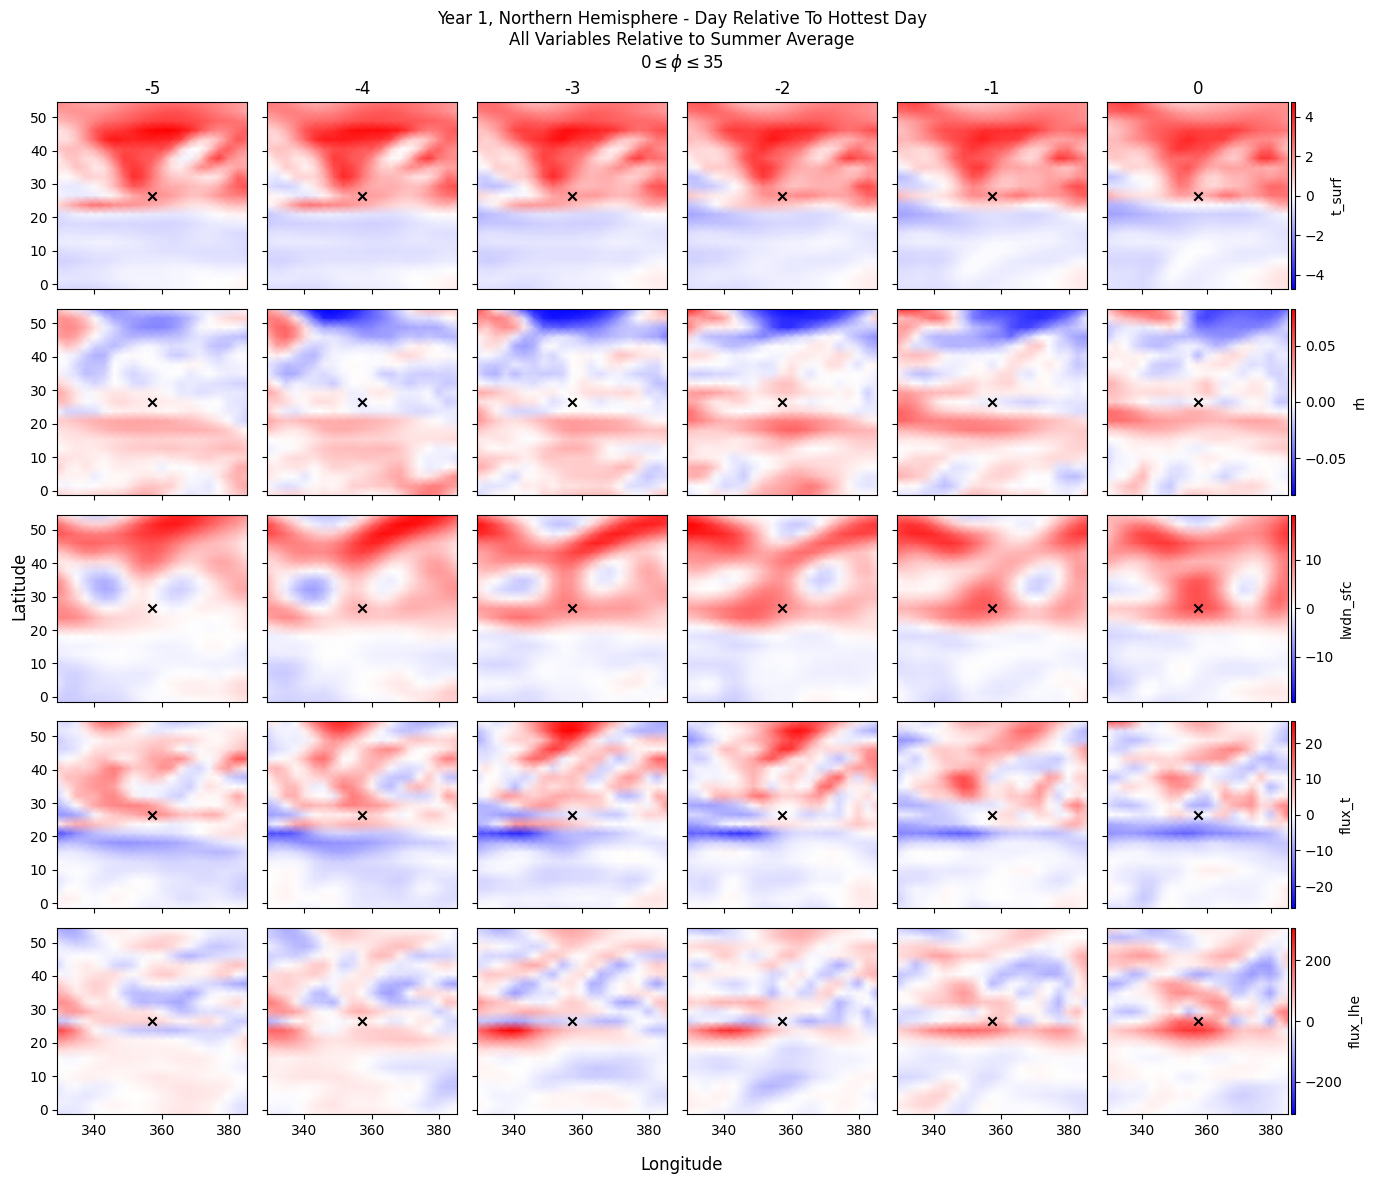

In [13]:
# Plot relative to summer mean
fig, ax = plt.subplots(len(var_name2), len(plot_day), figsize=(14,12), sharex=True, sharey=True)
for j, var in enumerate(var_name2):
    if var != 'rh':
        var_diff = plot_info[var] - np.expand_dims(ds_plot_av[var], axis=(0,2))
    else:
        rh_mean = ds_plot_av['sphum'].sel(pfull=pressure_surface) / sphum_sat(
            ds_plot_av.temp.sel(pfull=pressure_surface), pressure_surface*100)
        var_diff = plot_info[var] - np.expand_dims(rh_mean, axis=(0,2,3))
    clims = [-np.nanmax(np.abs(var_diff[:, :, :, 0])),
             np.nanmax(np.abs(var_diff[:, :, :, 0]))]
    for i in range(len(plot_day)):
        ax[0, i].set_title(plot_day[i])
        if var == 'omega':
            cmap = 'bwr_r'
        else:
            cmap = 'bwr'
        im = ax[j, i].pcolormesh(plot_info['lon'], plot_info['lat'], var_diff[i, :, :, 0], shading='gouraud',
                                 vmin=clims[0], vmax=clims[1], cmap=cmap)
        ax[j, i].scatter(max_coord[1], max_coord[0], marker='x', color='k')
        if var in ['ps', 'height']:
            pu, pv = (plot_info['ucomp']-np.expand_dims(ds_plot_av['ucomp'], axis=(0,2))
                      )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]], \
                (plot_info['vcomp']-np.expand_dims(ds_plot_av['vcomp'], axis=(0,2))
                 )[i, ::wind_spacing, ::wind_spacing, var_p_ind[j]]
            ax[j, i].quiver(plot_info['lon'][::wind_spacing], plot_info['lat'][::wind_spacing], pu, pv, alpha=0.5, color='k')
        if i == len(plot_day)-1:
            plt.colorbar(im, ax=ax[j, -1], label=var_name2[j],
                         aspect=cbar_param['aspect'], pad=cbar_param['pad'], fraction=cbar_param['fraction'])
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') +
             f' - Day Relative To Hottest Day\nAll Variables Relative to Summer Average\n${lat_min} \leq \\phi \leq {lat_max}$')
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout();

### Surface vs lower level temperature
The plots below show how the surface and lowest level temperatures evolve in the days around the hottest day of each year. Clearly, the highest surface temperature is not associated with the highest low level atmospheric temperature.

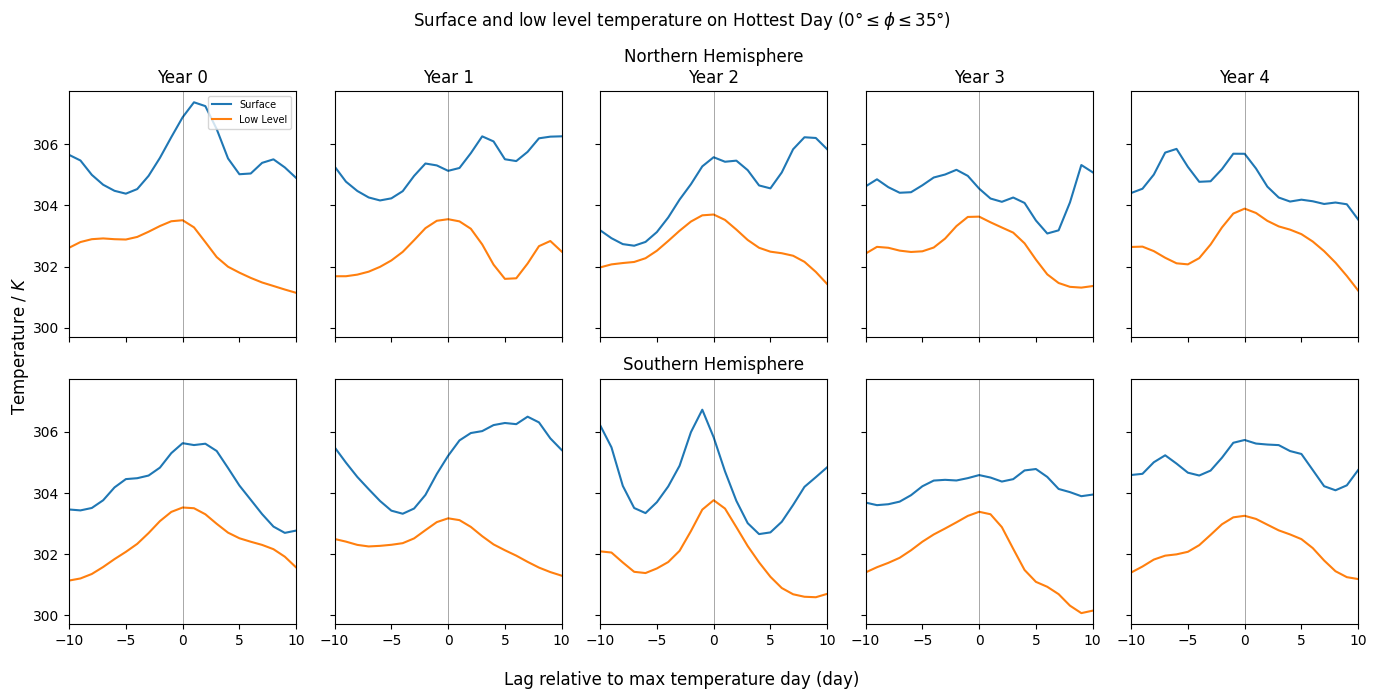

In [14]:
fig, ax = plt.subplots(2, n_years, figsize=(14,7), sharex=True, sharey=True)
for j in range(2):
    ax[j, int(np.floor(n_years/2))].set_title('Southern Hemisphere')
    for i in range(n_years):
        ax[j, i].plot(np.arange(-spatial_sz['time'],spatial_sz['time']+1),
                      max_info['t_surf'][i, j, spatial_sz['lat'], spatial_sz['lon']], label='Surface')
        ax[j, i].plot(np.arange(-spatial_sz['time'],spatial_sz['time']+1),
                      max_info['temp'][i, j, spatial_sz['lat'], spatial_sz['lon'], :, -1], label='Low Level')
        if i == int(np.floor(n_years/2)):
            if j == 0:
                ax[j, i].set_title(f'Northern Hemisphere\nYear {i}')
            else:
                ax[j, i].set_title(f'Southern Hemisphere')
        else:
            ax[0, i].set_title(f'Year {i}')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_xlim(-spatial_sz['time'], spatial_sz['time'])
ax[0, 0].legend(loc='upper right', fontsize=7)
fig.suptitle(f'Surface and low level temperature on Hottest Day (${lat_min}\degree \leq \\phi \leq {lat_max}\degree$)')
fig.supylabel('Temperature / $K$')
fig.supxlabel('Lag relative to max temperature day (day)')
plt.tight_layout()

### Shortwave flux on hottest day
The crosses in the plot below indicate the hottest days in each year of the simulation. The plot indicates the time of year that the hottest day occurs. Clearly, it does not coincide with the peak of short wave radiation recieved by the surface.

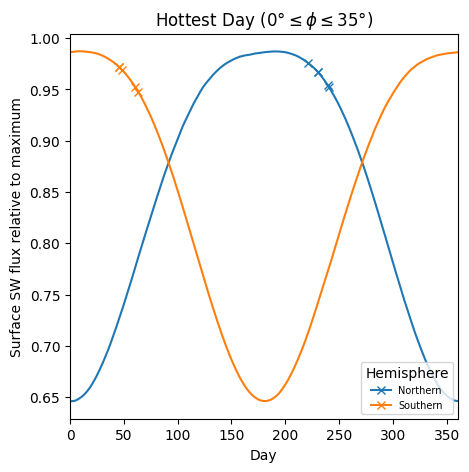

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sw_flux_mean = ds_use.where((ds_use.lat<=lat_max) & (ds_use.lat>=lat_min), drop=True).swdn_sfc
sw_flux_mean_nh = sw_flux_mean.where(sw_flux_mean.lat>0).mean(dim=['lon'])
sw_flux_mean_nh = annual_mean(area_weighting(sw_flux_mean_nh/(sw_flux_mean_nh.max(dim='time')+1e-20)).mean(dim='lat'))
ax.plot(sw_flux_mean_nh.time, sw_flux_mean_nh,'-x', markevery=numpy_indexed.indices(sw_flux_mean_nh.time, max_info['day'][:, 0]),
        label='Northern')
sw_flux_mean = ds_use.where((ds_use.lat>=-lat_max) & (ds_use.lat<=-lat_min), drop=True).swdn_sfc
sw_flux_mean_sh = sw_flux_mean.where(sw_flux_mean.lat<0).mean(dim=['lon'])
sw_flux_mean_sh = annual_mean(area_weighting(sw_flux_mean_sh/(sw_flux_mean_sh.max(dim='time')+1e-20)).mean(dim='lat'))
ax.plot(sw_flux_mean_sh.time, sw_flux_mean_sh,'-x',
        markevery=numpy_indexed.indices(sw_flux_mean_sh.time, max_info['day'][:, 1]), label='Southern')
ax.legend(title='Hemisphere', loc='lower right', fontsize=7)
ax.set_xlim(0,n_year_days)
ax.set_ylabel('Surface SW flux relative to maximum')
ax.set_xlabel('Day')
ax.set_title(f'Hottest Day (${lat_min}\degree \leq \\phi \leq {lat_max}\degree$)');

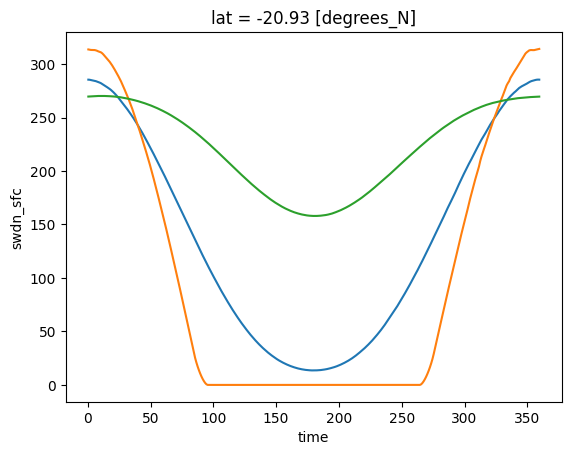

In [56]:
annual_mean(ds_use.sel(lat=-60, method='nearest').swdn_sfc).mean(dim='lon').plot()
annual_mean(ds_use.sel(lat=-90, method='nearest').swdn_sfc).mean(dim='lon').plot()
annual_mean(ds_use.sel(lat=-20, method='nearest').swdn_sfc).mean(dim='lon').plot()